In [ ]:
from os.path import join, dirname
from dotenv import load_dotenv
import os
from app.main import load_data
import streamlit as st
from snowflake import connector
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
from scipy.optimize import curve_fit

pd.options.display.float_format = '{:,.2f}'.format

# get environment variables
dotenv_path = join(dirname('streamlit_grs_fit\\app\\'), '.env')
load_dotenv(dotenv_path)
SF_ACCOUNT = os.getenv('SF_ACCOUNT')
SF_USER = os.getenv('SF_USER')
SF_PASSWORD = os.getenv('SF_PASSWORD')
SF_ROLE = os.getenv('SF_ROLE')
SF_WAREHOUSE = os.getenv('SF_WAREHOUSE')
SF_DATABASE = os.getenv('SF_DATABASE')
SF_SCHEMA = os.getenv('SF_SCHEMA')

In [342]:
query = 'select '+\
            'job, gcs_cost, grs_cost, hoisting_cost, addons_cost, direct_cost, direct_labor_cost, total_cost '+\
            ',div0(gcs_cost, direct_cost) gcs_per_direct '+\
            ',div0(grs_cost, direct_cost) grs_per_direct '+\
            ',div0(direct_labor_cost, direct_cost) labor_per_direct '+\
            'from sandbox.public.gcs_fit ' +\
            'where gcs_cost > 0.1'
            # f'where div0(direct_cost, gcs_cost) >= {min_gcs_ratio} '+\
            # f'and div0(direct_cost, gcs_cost) <= {max_gcs_ratio} '+\
            # f'and div0(direct_cost, grs_cost) >= {min_grs_ratio} '+\
            # f'and div0(direct_cost, grs_cost) <= {max_grs_ratio} '+\
            # f'and total_cost >= {min_total_costs} '+\
            # f'and total_cost <= {max_total_costs} '+\
df_data = load_data(query).set_index('JOB') 
df_data = pd.DataFrame(df_data)

In [343]:
df_filtered = df_data.loc[
                    (10 < df_data.TOTAL_COST) &
                    (0.05 < df_data.GCS_PER_DIRECT) & (df_data.GCS_PER_DIRECT < 500.7) &
                    (0.05 < df_data.GRS_PER_DIRECT) & (df_data.GRS_PER_DIRECT < 500.7)
]
df_filtered.head()

,GCS_COST,GRS_COST,HOISTING_COST,ADDONS_COST,DIRECT_COST,DIRECT_LABOR_COST,TOTAL_COST,GCS_PER_DIRECT,GRS_PER_DIRECT,LABOR_PER_DIRECT
JOB,,,,,,,,,,
7319,"126,626.00","114,978.00",NaN,"40,443.00","1,670,111.00","65,726.00","1,952,158.00",0.08,0.07,0.04
6559,"875,157.00","189,262.00",NaN,"18,688,553.00","6,026.00",36.00,"19,758,998.00",145.23,31.41,0.01
3749,"597,144.00","554,912.00","160,768.00","885,522.00","10,371,003.00","805,092.00","12,569,350.00",0.06,0.05,0.08
S5792,"15,164.00","4,030.00",NaN,"5,251.00","36,582.00","3,709.00","61,027.00",0.41,0.11,0.10
5596,"1,176,259.00","883,464.00",460.00,"1,323,342.00","16,986,046.00","898,123.00","20,369,571.00",0.07,0.05,0.05


In [344]:
df_addons = pd.DataFrame()
df_addons['gcs_and_grs'] = df_filtered.GCS_COST + df_filtered.GRS_COST
df_addons['direct_cost'] = df_filtered.DIRECT_COST
df_addons.describe()

,gcs_and_grs,direct_cost
count,"1,035.00","1,035.00"
mean,"349,914.93","1,464,846.60"
std,"2,065,686.12","11,115,519.25"
min,"1,202.00",24.00
25%,"8,209.00","13,195.50"
50%,"28,574.00","62,646.00"
75%,"104,158.50","308,269.50"
max,"35,278,028.00","228,508,477.00"


In [345]:
df_addons_vs_labor = pd.DataFrame()
df_addons_vs_labor['gcs_and_grs'] = df_filtered.GCS_COST + df_filtered.GRS_COST
df_addons_vs_labor['direct_labor_cost'] = df_filtered.DIRECT_LABOR_COST
df_addons_vs_labor.describe()

,gcs_and_grs,direct_labor_cost
count,"1,035.00","1,035.00"
mean,"349,914.93","77,399.13"
std,"2,065,686.12","553,374.62"
min,"1,202.00",0.00
25%,"8,209.00","1,244.00"
50%,"28,574.00","5,164.00"
75%,"104,158.50","18,474.00"
max,"35,278,028.00","11,787,517.00"


In [382]:
df_grs_gcs = pd.DataFrame()
df_grs_gcs['gcs'] = df_filtered.GCS_COST
df_grs_gcs['grs'] = df_filtered.GRS_COST
df_grs_gcs.describe()

,gcs,grs
count,"1,035.00","1,035.00"
mean,"205,080.83","144,834.10"
std,"1,220,249.12","920,213.37"
min,"1,002.00",66.00
25%,"4,553.00","2,760.00"
50%,"15,333.00","10,445.00"
75%,"61,320.00","37,429.00"
max,"23,740,523.00","17,961,137.00"


In [ ]:
df_grs = pd.DataFrame()
df_grs['grs'] = df_filtered.GRS_COST
df_grs['direct_cost'] = df_filtered.DIRECT_COST
df_grs.describe()

In [ ]:
np.array(df_addons.iloc[:,0])

In [429]:
known_grs_costs = None
known_gcs_costs = None
def func(x, a, b, c): # x-shifted log
    return a*np.log(x + b)+c

def ModelAndScatterPlot(df, graphWidth, graphHeight, job_name, input_costs):
    feature_name = df.iloc[:,1:].columns[0].replace("_", " ").upper()
    target_name = df.iloc[:,0:1].columns[0].replace("_", " ").upper()
    xData = np.array(df.iloc[:,1])
    yData = np.array(df.iloc[:,0])

    # these are the same as the scipy defaults
    initialParameters = np.array([1.0, 1.0, 1.0])

    # curve fit the test data
    fittedParameters, pcov = curve_fit(func, xData, yData, initialParameters, maxfev=50000)
    modelPredictions = func(xData, *fittedParameters) 
    absError = modelPredictions - yData

    SE = np.square(absError) # squared errors
    MSE = np.mean(SE) # mean squared errors
    RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (np.var(absError) / np.var(yData))

    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xData, yData,  'o', alpha=0.3, label='actual data')

    # create data for the fitted equation plot
    xModel = np.linspace(min(xData), max(xData))
    yModel = func(xModel, *fittedParameters)

    # now the upper bound
    axes.plot(xModel, yModel + RMSE, c='b', alpha=0.5, linestyle='--', linewidth=0.7, label=f'{target_name} + σ')

    # now the model as a line plot
    axes.plot(xModel, yModel, c='g', linewidth=1, label=f'{target_name} ls regression')

    # now the lower bound
    axes.plot(xModel, yModel - RMSE, c='r', alpha=0.5, linestyle='--', linewidth=0.7, label=f'{target_name} - σ')

    # color +/- 1 std devialtion
    axes.fill_between(xModel, yModel + RMSE, yModel - RMSE, alpha=0.15)

    # now a test value
    prediction = fittedParameters[0] * np.log( input_costs + fittedParameters[1]) + fittedParameters[2]
    j, k = input_costs, prediction
    plt.text(0.1, 0.8, f'{job_name}: {feature_name} = ${input_costs:,.0f}',ha='left',va='top', weight='bold',transform = axes.transAxes)
    axes.scatter(j, k+RMSE, c='b', marker='D', label=f'{job_name}, {target_name} + σ')
    axes.annotate(f'{target_name} + σ = ${prediction+RMSE:,.0f}', (j+100, k+RMSE+100))
    axes.scatter(j, k, c='g', marker='D', label=f'{job_name} Predicted {target_name}')
    axes.annotate(f'Predicted {target_name} = ${prediction:,.0f}', (j+100, k+100))
    axes.scatter(j, k-RMSE, c='r', marker='D', label=f'{job_name}, {target_name} - σ')
    axes.annotate(f'{target_name} - σ = ${prediction-RMSE:,.0f}', (j+100, k-RMSE+100))

    #values if known
    if (target_name == 'GRS') & (known_grs_costs is not None):
        figure_check = f'Known {target_name} = ${known_grs_costs:,.0f}, prediction + {(known_grs_costs-prediction)/RMSE} * σ\n\n'
        h, i = input_costs, known_grs_costs
        axes.scatter(h, i, c='k', marker='D', label=f'{job_name} Known {target_name}')
    elif (target_name == 'GCS') & (known_gcs_costs is not None):
        figure_check = f'Known {target_name} = ${known_grs_costs:,.0f}, prediction + {(known_gcs_costs-prediction)/RMSE} * σ\n\n'
        o, p = known_grs_costs, known_gcs_costs
        axes.scatter(o, p, c='k', marker='D', label=f'{job_name} Known {target_name}')
    else:
        figure_check = '\n'


    # labels and stuff
    axes.set_xlabel(feature_name)
    axes.set_ylabel(target_name)
    fmt = '${x:,.0f}'
    tick = StrMethodFormatter(fmt)
    axes.xaxis.set_major_formatter(tick)
    axes.yaxis.set_major_formatter(tick)
    axes.legend(loc='lower right')

    details = f'{job_name}: {feature_name} = ${input_costs:,.0f}, Predicted {target_name}: ${prediction:,.0f}\n'+\
                        f'{figure_check}'+\
                        f'Parameters: {fittedParameters}\n'+\
                        f'Function:  {fittedParameters[0]} * ln( x + {fittedParameters[1]}) + {fittedParameters[2]}\n'+\
                        f'RMSE: {RMSE}\n'+\
                        f'R-squared: {Rsquared}'
    
    return f, details, prediction

PATH: DIRECT COST = $14,000,000, Predicted GRS: $1,073,190

Parameters: [ 3.83795125e+09  5.18209866e+10 -9.46862930e+10]
Function:  3837951246.2731338 * ln( x + 51820986641.22472) + -94686293043.92393
RMSE: 413792.19736737775
R-squared: 0.797601483377288


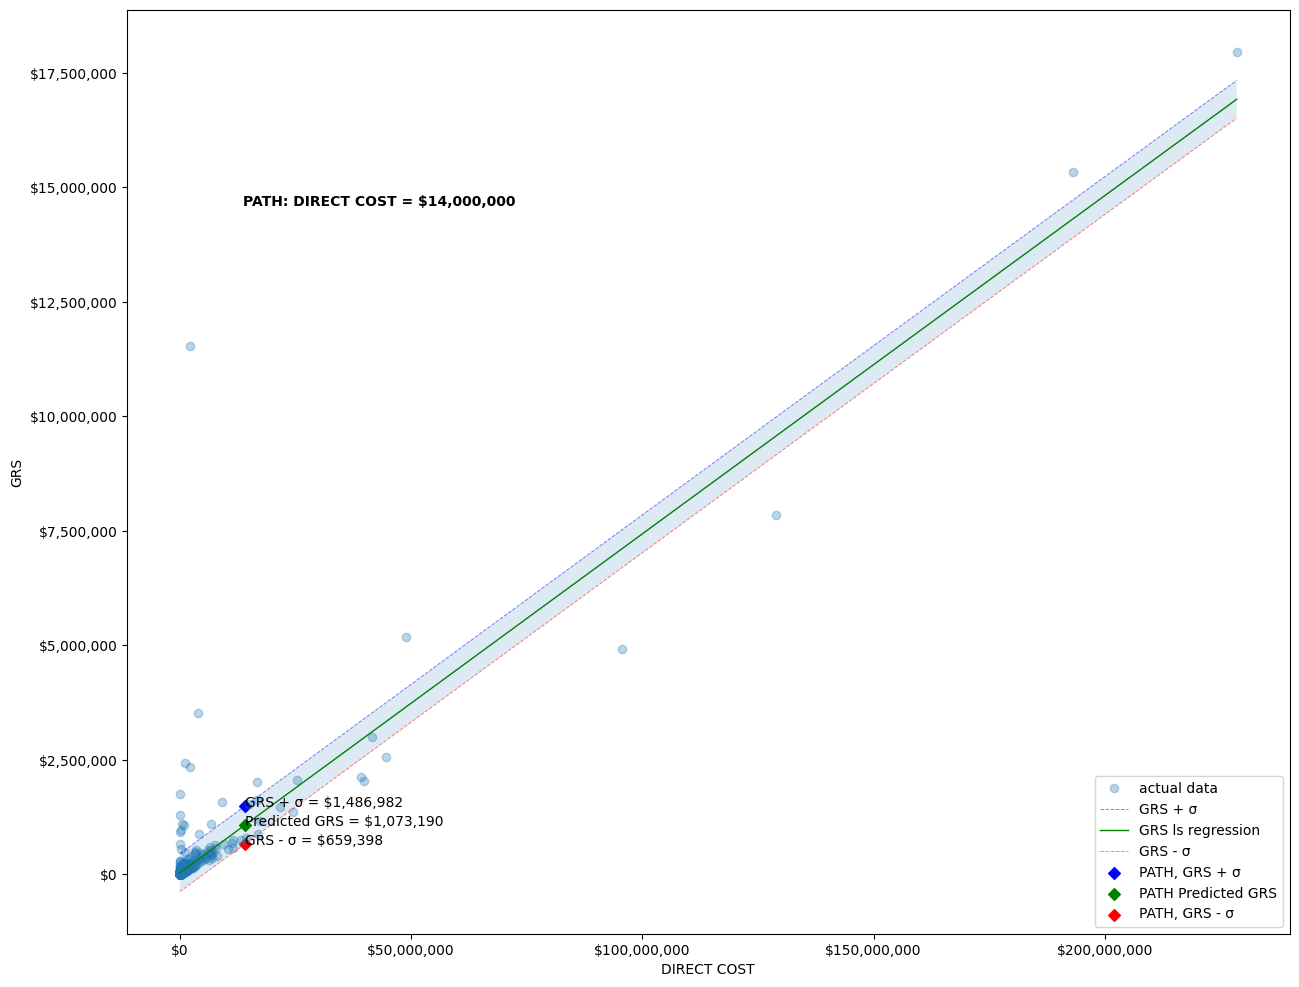

In [430]:
graphWidth = 1500
graphHeight = graphWidth * 800 / 1000
f, details, grs_prediction = ModelAndScatterPlot(df_grs, graphWidth, graphHeight, 'PATH', 14000000)
f.show()
print(details)

PATH: GRS = $1,073,190, Predicted GCS: $1,935,605
Known GCS = $1,573,190, prediction + 0.5240973557133488 * σ

Parameters: [ 1.41280845e+07  7.23296933e+06 -2.23160213e+08]
Function:  14128084.512594532 * ln( x + 7232969.328821181) + -223160213.13882276
RMSE: 572412.4112983526
R-squared: 0.7797373341600853


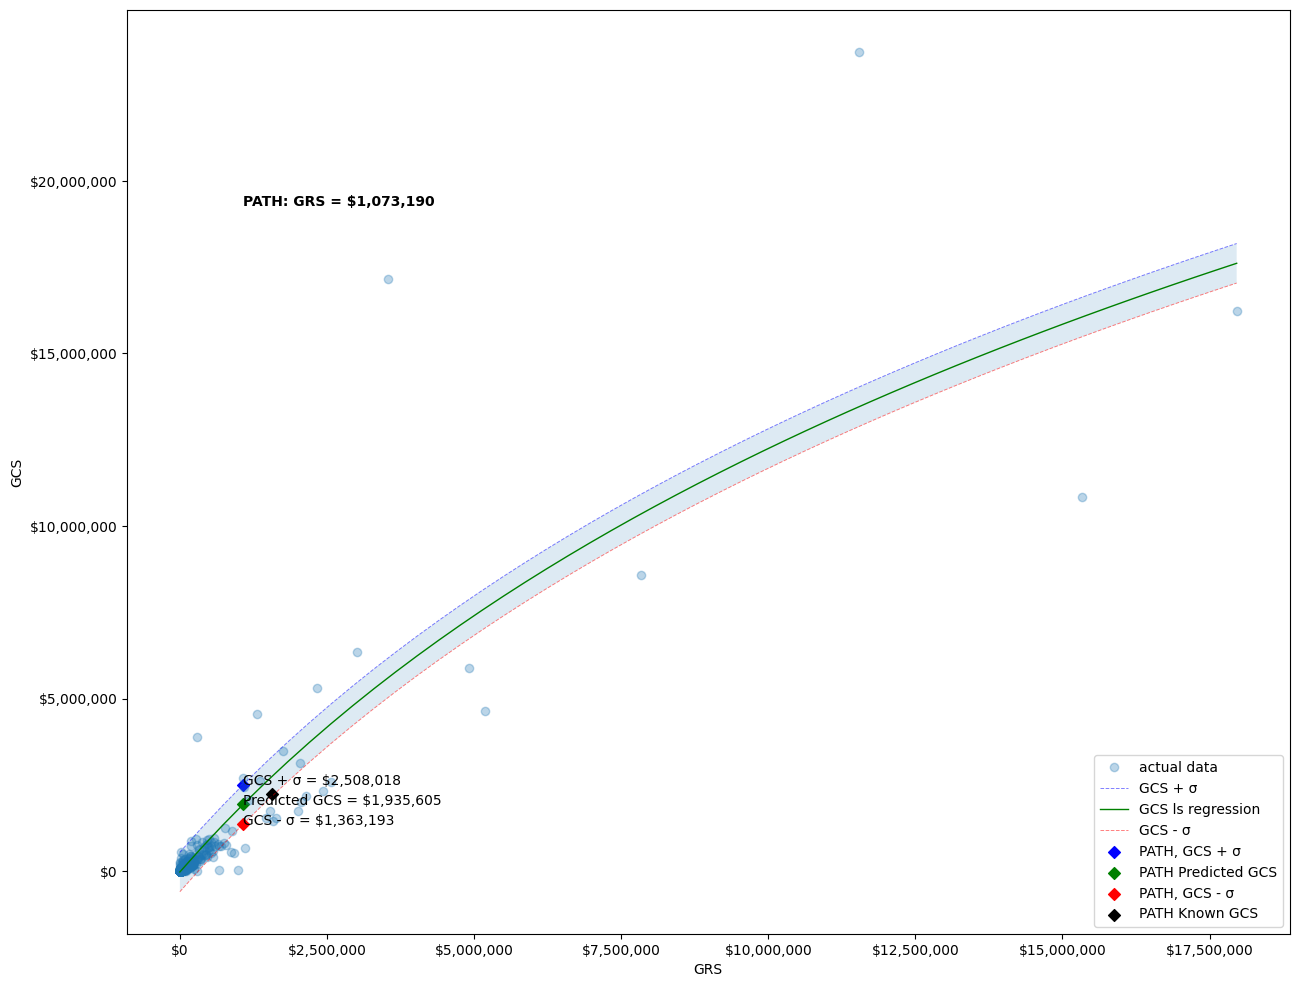

In [421]:
f, details, gcs_prediction = ModelAndScatterPlot(df_grs_gcs, graphWidth, graphHeight, 'PATH', grs_prediction)
f.show()
print(details)

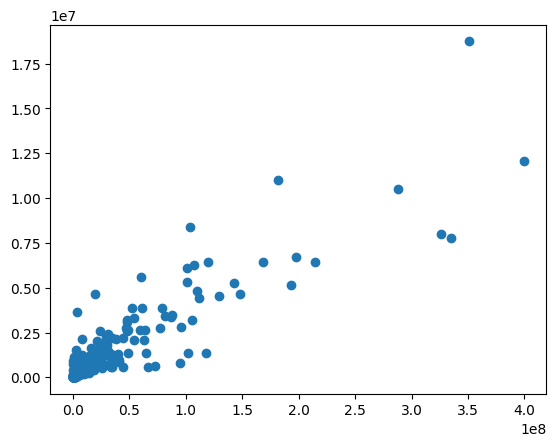

In [172]:
def peel(x):
    return np.reciprocal(np.square(x))

def unpeel(x):
    return np.sqrt(np.reciprocal(x))

x = np.array(df_data.DIRECT_COST.loc[(0 < df_data.ADDONS_COST) & (df_data.ADDONS_COST < 30_000_000)])
x = peel(x)
y = np.array(df_data.ADDONS_COST.loc[(0 < df_data.ADDONS_COST) & (df_data.ADDONS_COST < 30_000_000)])
# plt.scatter(x,y)
# plt.scatter(np.sqrt(np.reciprocal(x)),y)
plt.scatter(unpeel(x),y)
plt.show()

alpha=9429981.043124162, beta=-6546757371914022.0


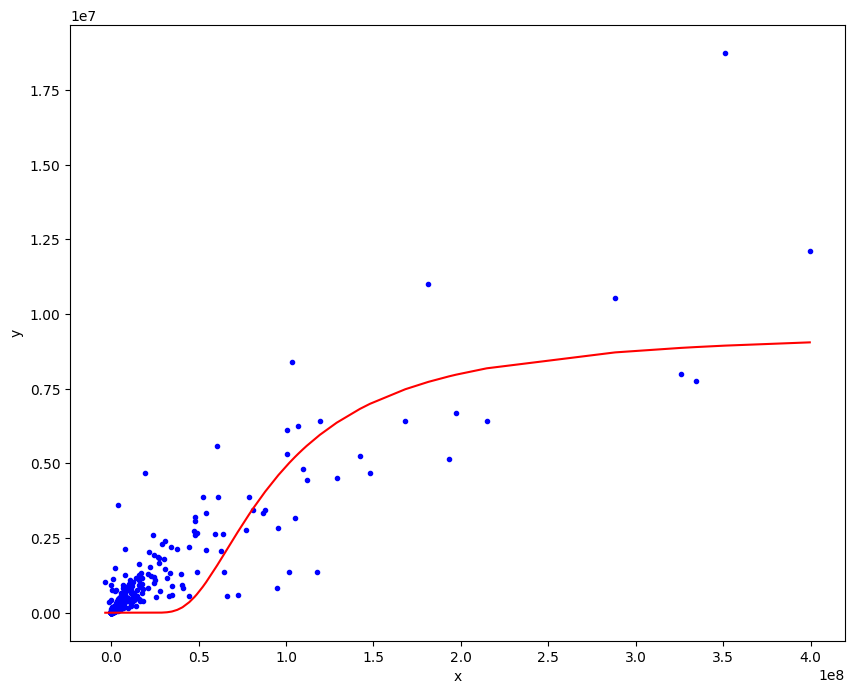

In [181]:
def func(x, a, b):
    y = a*np.exp(b*x)
    return y

def recip_square(x):
    return np.reciprocal(np.square(x))

def un_recip_square(x):
    return np.sqrt(np.reciprocal(x))

x = np.array(df_data.DIRECT_COST.loc[(0 < df_data.ADDONS_COST) & (df_data.ADDONS_COST < 30_000_000)])
y = np.array(df_data.ADDONS_COST.loc[(0 < df_data.ADDONS_COST) & (df_data.ADDONS_COST < 30_000_000)])

x_recip_square = recip_square(x)

# alpha, beta = curve_fit(func, xdata = x, ydata = y)[0]
alpha, beta = curve_fit(func, xdata = x_recip_square, ydata = y)[0]
print(f'alpha={alpha}, beta={beta}')
plt.figure(figsize = (10,8))
plt.plot(x, y, 'b.')
plt.plot(np.sort(x), np.sort(alpha*np.exp(beta*x_recip_square)), 'r')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [269]:
def func(x, a, b):
    y = a*np.exp(b*x)
    return y

def recip_square(x):
    return np.reciprocal(np.square(x))

def un_recip_square(x):
    return np.sqrt(np.reciprocal(x))

def rdx_ModelAndScatterPlot(df, graphWidth, graphHeight, job_name, direct_costs):
    feature_name = df.iloc[:,1:].columns[0]
    target_name = df.iloc[:,0:1].columns[0]
    xData = np.array(df.iloc[:,1])
    x_recip_square = recip_square(xData)
    yData = np.array(df.iloc[:,0])
    
    alpha, beta = curve_fit(func, xdata = x_recip_square, ydata = yData)[0]
    modelPredictions = np.sort(func(x_recip_square,alpha,beta))
    absError = modelPredictions - yData
    SE = np.square(absError) # squared errors
    MSE = np.mean(SE) # mean squared errors
    RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (np.var(absError) / np.var(yData))

    print(f'alpha={alpha}, beta={beta}')
    print(f'Function: {alpha} * e({beta} * x)')
    print('RMSE:', RMSE)
    print('R-squared:', Rsquared)

    print()

    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xData, yData,  'o', alpha=0.3, label='actual data')

    # create data for the fitted equation plot
    xModel, yModel = np.sort(xData), modelPredictions

    # now the upper bound
    axes.plot(xModel, yModel + RMSE, c='b', alpha=0.5, linestyle='--', linewidth=0.7, label=f'{target_name} + σ')

    # now the model as a line plot
    axes.plot(xModel, yModel, c='g', linewidth=1, label=f'{target_name} ls regression')

    # now the lower bound
    axes.plot(xModel, yModel - RMSE, c='r', alpha=0.5, linestyle='--', linewidth=0.7, label=f'{target_name} - σ')

    # color +/- 1 std devialtion
    axes.fill_between(xModel, yModel + RMSE, yModel - RMSE, alpha=0.15)

    # now a test value
    # job_name = job_name
    # direct_costs = direct_costs
    # addon = func(recip_square(direct_costs),alpha,beta)
    # j, k = direct_costs, addon
    # print(addon)
    # plt.text(0.1, 0.8, f'{job_name}: Direct Costs = ${direct_costs:,.0f}',ha='left',va='top', weight='bold',transform = axes.transAxes)
    # axes.scatter(j, k+RMSE, c='b', marker='D', label=f'{job_name}, {target_name} + σ')
    # axes.annotate(f'{target_name} + σ = ${addon+RMSE:,.0f}', (j+100, k+RMSE+100))
    # axes.scatter(j, k, c='g', marker='D', label=f'{job_name} Predicted {target_name}')
    # axes.annotate(f'Predicted {target_name} = ${addon:,.0f}', (j+100, k+100))
    # axes.scatter(j, k-RMSE, c='r', marker='D', label=f'{job_name}, {target_name} - σ')
    # axes.annotate(f'{target_name} - σ = ${addon-RMSE:,.0f}', (j+100, k-RMSE+100))

    # labels and stuff
    axes.set_xlabel(feature_name)
    axes.set_ylabel(target_name)
    axes.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    axes.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

    plt.legend()
    plt.show()
    plt.close('all') # clean up after using pyplot

In [236]:
alpha = 27724596.905310903
beta = -1.0946287131342262e+16
direct_costs = 140000000
func(direct_costs,alpha,beta)

27724596.905310903

alpha=4717235.7974571455, beta=-2095363500257.5928
Function: 4717235.7974571455 * e(-2095363500257.5928 * x)
RMSE: 5888740.542509481
R-squared: -0.13531878916968276



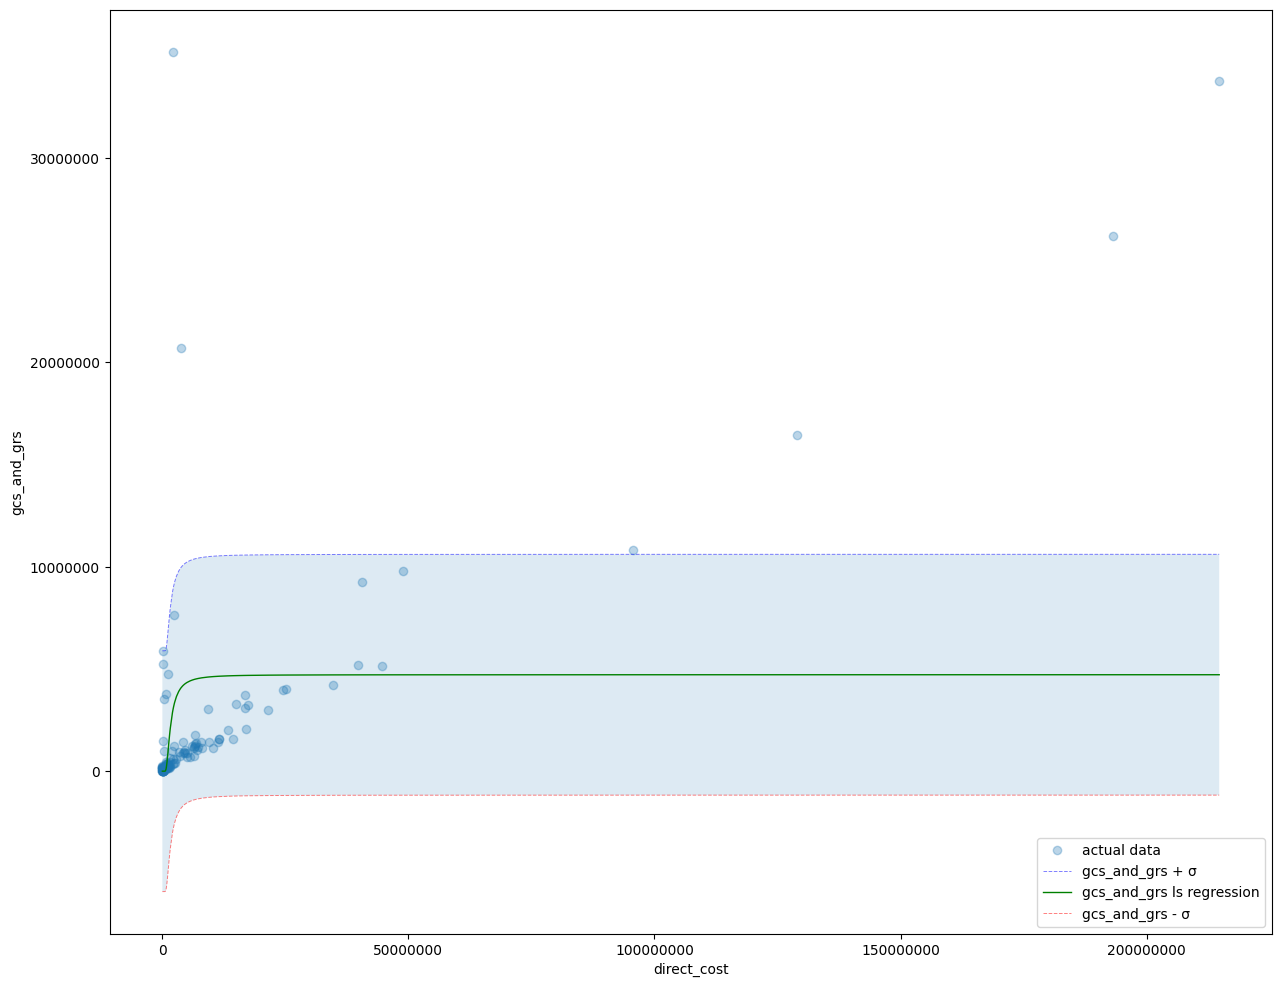

In [271]:
rdx_ModelAndScatterPlot(df_addons, graphWidth, graphHeight, 'PATH', 140000000)

In [278]:
def func(x, a, b):
    y = a*np.exp(b*x)
    return y

def recip_square(x):
    return np.reciprocal(np.square(x))

def un_recip_square(x):
    return np.sqrt(np.reciprocal(x))

def rdx_ModelAndScatterPlot(df, graphWidth, graphHeight, job_name, direct_costs):
    feature_name = df.iloc[:,1:].columns[0]
    target_name = df.iloc[:,0:1].columns[0]
    xData = np.array(df.iloc[:,1])
    yData = np.array(df.iloc[:,0])
    x_recip_square = xData
    y_recip_square = recip_square(yData)
    
    alpha, beta = curve_fit(func, xdata = x_recip_square, ydata = y_recip_square)[0]
    modelPredictions = np.sort(func(x_recip_square,alpha,beta))
    absError = modelPredictions - y_recip_square
    SE = np.square(absError) # squared errors
    MSE = np.mean(SE) # mean squared errors
    RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (np.var(absError) / np.var(yData))

    print(f'alpha={alpha}, beta={beta}')
    print(f'Function: {alpha} * e({beta} * x)')
    print('RMSE:', RMSE)
    print('R-squared:', Rsquared)

    print()

    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(x_recip_square, y_recip_square,  'o', alpha=0.3, label='actual data')

    # create data for the fitted equation plot
    xModel, yModel = np.sort(x_recip_square), modelPredictions

    # now the upper bound
    axes.plot(xModel, yModel + RMSE, c='b', alpha=0.5, linestyle='--', linewidth=0.7, label=f'{target_name} + σ')

    # now the model as a line plot
    axes.plot(xModel, yModel, c='g', linewidth=1, label=f'{target_name} ls regression')

    # now the lower bound
    axes.plot(xModel, yModel - RMSE, c='r', alpha=0.5, linestyle='--', linewidth=0.7, label=f'{target_name} - σ')

    # color +/- 1 std devialtion
    axes.fill_between(xModel, yModel + RMSE, yModel - RMSE, alpha=0.15)

    # now a test value
    # job_name = job_name
    # direct_costs = recip_square(direct_costs)
    # addon = func(direct_costs,alpha,beta)
    # j, k = direct_costs, addon
    # print(addon)
    # plt.text(0.1, 0.8, f'{job_name}: Direct Costs = {un_recip_square(direct_costs):,.2f}',ha='left',va='top', weight='bold',transform = axes.transAxes)
    # axes.scatter(j, k+RMSE, c='b', marker='D', label=f'{job_name}, {target_name} + σ')
    # axes.annotate(f'{target_name} + σ = ${addon+RMSE:,.0f}', (j+100, k+RMSE+100))
    # axes.scatter(j, k, c='g', marker='D', label=f'{job_name} Predicted {target_name}')
    # axes.annotate(f'Predicted {target_name} = ${addon:,.0f}', (j+100, k+100))
    # axes.scatter(j, k-RMSE, c='r', marker='D', label=f'{job_name}, {target_name} - σ')
    # axes.annotate(f'{target_name} - σ = ${addon-RMSE:,.0f}', (j+100, k-RMSE+100))

    # labels and stuff
    axes.set_xlabel(feature_name)
    axes.set_ylabel(target_name)
    axes.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axes.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    plt.legend()
    plt.show()
    plt.close('all') # clean up after using pyplot

alpha=1.0, beta=1.0
Function: 1.0 * e(1.0 * x)
RMSE: inf
R-squared: nan



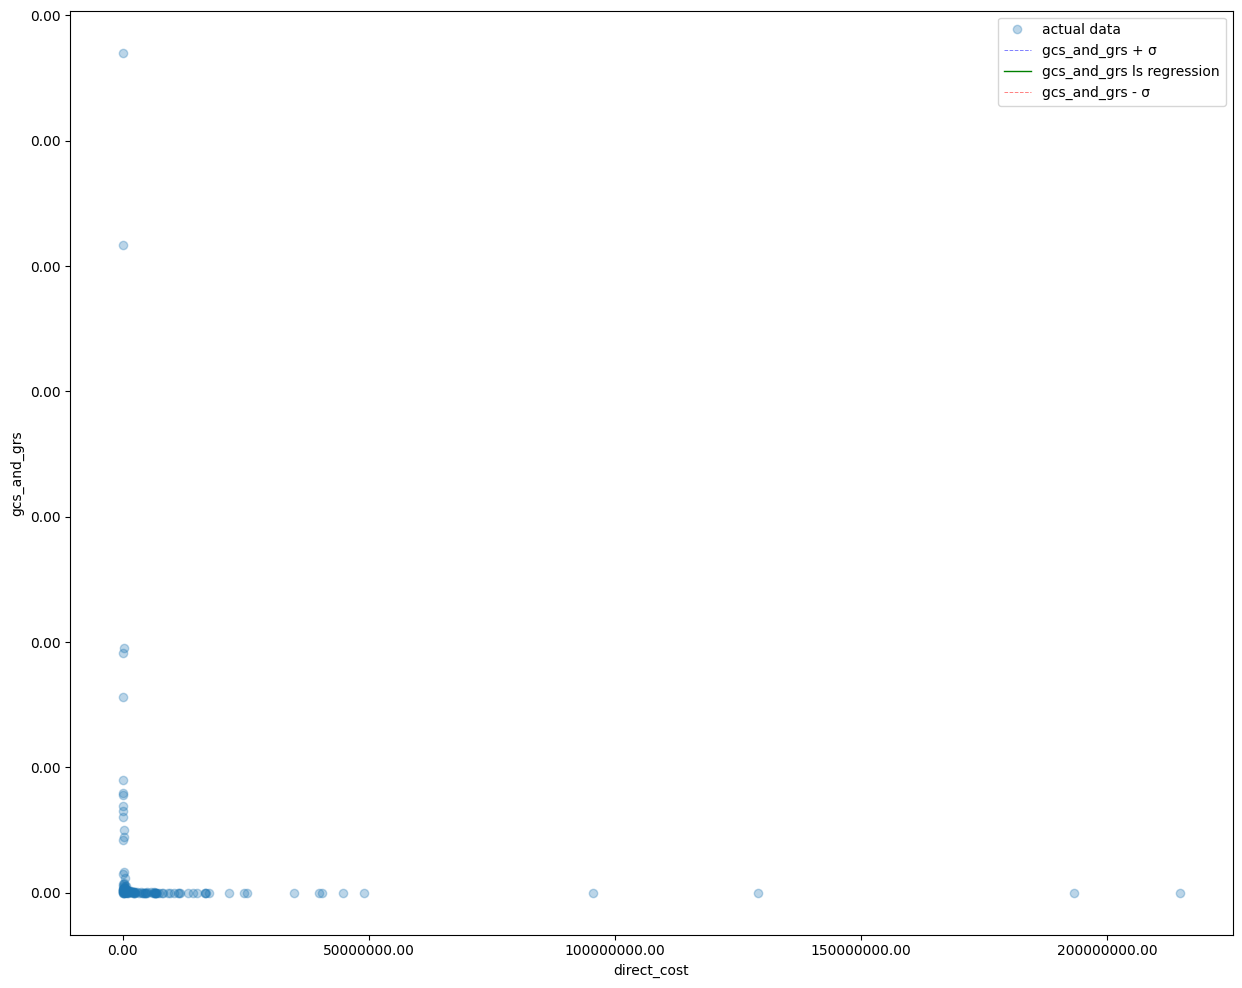

In [279]:
rdx_ModelAndScatterPlot(df_addons, graphWidth, graphHeight, 'PATH', 140000000)

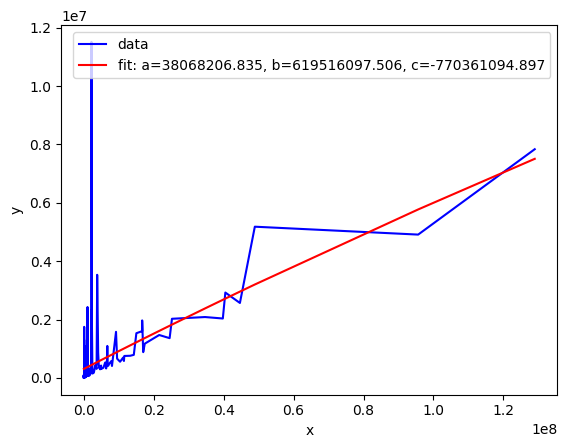

In [340]:
def adjust_to_std(X):
    for col in range(X.shape[0]):
        X[col] = X[col] / np.std(X[col])
    return X

df = df_grs.loc[df_grs['direct_cost'] / df_grs['grs'] < 12]
# df = df_grs
df = np.array(df)
# df = adjust_to_std(df)
df = df[df[:, 1].argsort()]
# df_filtered = df[:-2,:]
# df[:,1] = np.reciprocal(np.square(df[:,1]))
xdata = np.array(df_filtered[:,1])
ydata = np.array(df_filtered[:,0])

# def func(x, a, b, c):
#     return a * np.exp(-b * x) + c

def func(x, a, b, c): # x-shifted log
    return a*np.log(x + b)+c

plt.plot(xdata, ydata, 'b-', label='data')
popt, pcov = curve_fit(func, xdata, ydata)
plt.plot(xdata, func(xdata, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [339]:

tests = pd.DataFrame(df[:,:])
tests['tests'] = tests[1] / tests[0]
tests #.loc[tests[1] / tests[0] < 16]

,0,1,tests
0,131.00,994.00,7.59
1,"23,388.00","1,912.00",0.08
2,"50,085.00","2,507.00",0.05
3,"76,371.00","6,285.00",0.08
4,"70,569.00","7,653.00",0.11
...,...,...,...
119,"5,182,749.00","48,914,896.00",9.44
120,"4,912,149.00","95,633,243.00",19.47
121,"7,838,170.00","128,978,241.00",16.46
122,"15,329,618.00","193,194,357.00",12.60


In [304]:
a = np.array([[9, 2, 3],
           [4, 5, 6],
           [7, 0, 5]])
a[:-1,:]

array([[9, 2, 3],
       [4, 5, 6]])